**CONTENT**

The calibration process is slightly different for the spatial model. In this notebook we will first explore the various challenges and options concerning calibration of the spatial model. Next, this is the scratch environment for the creation of new functions, if need be.

**OPEN TASKS**

*short term*  
1. Think about another way to downgrade the number of contacts (which is now done with the `prevention` parameter). Or as Tijs says it:
>die 'downgrade' de contacten omdat slechts 1/3 contacten tot transmissie lijkt te leiden. Dit wil ik zelf wegdoen in een volgende modelversie omdat hier ook het effect van het weer inzit ed. Als je een andere oplossing kan bedenken is die meer dan welkom. Ik dacht eraan om bvb te spelen met de contactintensiteiten in de modellen (bvb calibratie op enkel 5 min plus) of tijdens de lockdown alle contacten eruit onder 1h in lengte. Die optie zit in de contact matrix inlaadfunctie.
2. Aggregate Belgian arrondissements in three regions: metropolitan, urban and rural
3. Fix the model attributes to be `parameters` again (rather than taking 29 individual parameters), because this structure is used in the `MLE` function. Just put this restructuring of `parameters` dictionary in the save and open functions. Otherwise this will never work.
4. CURRENT ERROR,
```
    operands could not be broadcast together with shapes (7,) (12,38)
```
is associated with the `obj` function in `pso.py`, which is associated with `func`, which is the `MLE` in our case. The map from `obj` to `x` cannot happen because `obj` and `x` do not have the same dimensions.

*long term*  
1. test

**OPEN QUESTIONS**

1. What are the parameters sigma_H_in and extraTime that the MCMC is running over?
2. What does `emcee.Ensemblesampler` do exactly? Reference: [this link](https://emcee.readthedocs.io/en/stable/user/sampler/)
3. Is it fair to start with an initialised model and only shift it horizontally? Isn't it possible to also run an MCMC on different initialisations?
4. What goes wrong when executing `fit_pso`? Arguably the model is not good.
5. Would it be useful to use constraining functions in the PSO optimisation?
6. What is the effect of using other `objective_fcn`s? Instead of `MLE` use `SSE`, for example. Are these 'choices', or is there a strong preference/necessity for one?
>An explanation of the difference between SSE and MLE can be found [here](https://emcee.readthedocs.io/en/stable/tutorials/line/). Brief summary: if measurement noise is unbiased, Gaussian and independent than the MLE and SSE are identical.

7. The example use in the function description of `MLE` function says `MLE(model,thetas,data,parNames,positions)`, but this does not correspond to the look of the function itself (`def MLE(thetas,BaseModel,data,states,parNames,samples=None):`). Is this some Python magic?
8. PROBLEM -- For full calibration of every arrondissement *I will quite certainly need supercomputer time*. To calculate the maximum likelihood, a simulation is made every time. For 43 arrondissements and 5000 MCMC steps this means that on my pc this will need at least 20 hours to run. This problem **cannot** be circumvented by aggregating results, because this only happens a posteriori.

# Load packages

In [17]:
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# Custom package covid19model
from covid19model.models import models
from covid19model.models.utils import name2nis, social_policy_func, save_sim, open_sim
from covid19model.data import model_parameters #, sciensano, google
from covid19model.visualization.output import population_status, infected, show_map, show_graphs

# Download function for complete calibration
from covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explore `0.1-twallema-calibration-stochastic.ipynb`

*Steps*  
1. Hospitalisation data from 15-21 March is taken
2. Parameters that are being varied over are `sigma_H_in`, `extraTime` and `beta`. `sigma_H_in` is the uncertainty on `H_in`, `extraTime` is the time between day 0 of the initialised simulation (with e.g. E=10 people) and day 0 of the time series. Not sure if I like this.
3. Bounds for flat priors are given
4. Particle Swarm Optimisation (`MCMC.fit_pso`) is executed to find the maximum likelihood estimates of model parameters mentioned above
5. Resulting extraTime is added as model attribute and the other parameter values are used as initial values for the MCMC (typically: four slightly different initial points (nwalkers)). The MCMC happens in two dimensions with four walkers  (paths)
6. Ensemble sampler is used from the `emcee` sampler. I'm not entirely sure what this means
7. It appears that the beta parameter is *first* calibrated, and only *later on* the compliance parameters. The reason is that beta is best calibrated to data before any measures ('pure beta')

# Explore `run_optimization.py`

This function summarises much of the notebook described above. Difference between `full_calibration_wave1` and `full_calibration_wave2` is that the first one focuses on the March/April wave, whilst the latter focuses on the October/November wave.

**input**
Contains a function called `full_calibration_wave1` that takes in the following arguments:
1. `model`: initialised model object (such as the output of the `COVID19_SEIRD_sto_spatial` function)
2. `timeseries`: `pandas` Series Sciensano data to fit with date in index. Take from private data (if such is already available)
3. `spatial_unit`: name of the resulting files (e.g. Gent, Flanders, ...). Simply for *naming*
4. `start_date`: YYYY-MM-DD string for first day in the data to fit on
5. `end_beta`: YYYY-MM-DD string for last day to fit beta on
6. `end_ramp`: YYYY-MM-DD string for last day to fit compliance parameters on
7. `fig_path`: directory to save output figures in
8. `samples_path`: directory to save samples in. This is of the shape
```
    samples_dict={'calibration_data':states[0][0], 'start_date':start_date,
                  'end_beta':end_beta, 'end_ramp':end_ramp,
                  'maxiter': maxiter, 'popsize':popsize, 'steps_mcmc':steps_mcmc,
                  'R0':R0, 'R0_stratified_dict':R0_stratified_dict,
                  'lag_time': lag_time, 'beta': samples_beta['beta'],
                  'l': flat_samples_ramp[:,1].tolist(),'tau':flat_samples_ramp[:,2].tolist(),
                  'prevention':flat_samples_ramp[:,3].tolist()}
```
9. `initN`: total initial population
10. `Nc_total`: total interaction matrix
11. `maxiter`: maximal number of particle swarm steps
12. `popsize`: maximal number of particles in the swarm
13. `steps_mcmc`: iterations of the Monte Carlo simulation. 5000 steps in the national model takes about half an hour. Default is 10000

**output**

**notes**
1. `H_in` is hardcoded: if we want to choose e.g. the number of exposed people we need to fill in another string value here
2. Prior bounds of the PSO are hardcoded and may be adjusted (but probably these boundaries are wide enough)
3. PSO optimisation happens with the `fit_pso` function in `MCMC.py`, which contains all aid functions for executing the Markov Chain Monte Carlo simulation. `fit_pso` basically addresses the main function in `pso.py` called `optim`: it *only* takes the first return value of this function, which is needed for the MCMC. Description of `fit_pso`:
```
    A function to compute the mimimum of the absolute value of the maximum likelihood estimator using a particle swarm optimization
```
it must take in a certain function and boundaries for the function's varied parameters. 
4. The function this particle swarm attempts to minimize is called `MLE` in the module `objective_fcns.py`:
```
    A function to return the maximum likelihood estimator given a model object and a dataset
```
5. The args given to the `optim` function are "additional arguments passed to objective and constraint functions". They are
```
    args=(model,data,states,parNames,samples)
```
6. Additional arguments are hardcoded and not very important:
```
    processes=mp.cpu_count()-1),minfunc=1e-9, minstep=1e-9,debug=True, particle_output=True
```
`multiprocessing.cpu_count()-1` returns the number of processors in the system minus 1. If there are more than two processors, some fancy `multiprocessing.Pool` object is created (computer stuff)  

7. What happens to the `args` arguments (model,data,states,parNames,samples) in `fit_pso`?
    * They run through `functools`'s `partial` function, which fixes some function arguments:
    >The partial() is used for partial function application which “freezes” some portion of a function’s arguments and/or keywords resulting in a new object with a simplified signature. For example, partial() can be used to create a callable that behaves like the int() function where the base argument defaults to two
    * The effect here is that the arguments `args` are fixed to the `MLE` function, so in effect `MLE(args)` is executed. QUESTION: why this detour? Code-technical stuff.
    * No constraining functions are given, so "No constraints given" is printed.
    * `is_feasible = partial(_is_feasible_wrapper, cons)` checks whether no additional constraints are violated. In our case, this is always `True`
    * Then the actual PSO is coded (raw) and returns a coordinate array of "The swarm's best known position (optimal design)"
7. **the secret is in the `MLE` function**, which takes as arguments `model, data, states, parNames, samples`:
> A function to return the maximum likelihood estimator given a model object and a dataset

    * returns the total sum of squared errors, which is why it is minimised!
    * In the first step, updates the parameters to initial guesses. In the special case where the parameter is called `extraTime`, the model attribute `extraTime` is set to its value (rather than a parameter in the `parameter` attribute)
    * the `extraTime` magic happens at line 130: `T = max(data_length)+BaseModel.extraTime-1`

**Load model**

In [57]:
# Load model parameters
spatial = 'arr'
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(spatial=spatial)
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=spatial)

# Load initial state: one thirty year old exposed individual in every arrondissement
G, N = initN.shape[0], initN.shape[1]
E = np.zeros([G,N])
for g in range(G):
    E[g,3] = 1
states = dict({'S' : initN, 'E' : E})

# Load model
model = models.COVID19_SEIRD_sto_spatial(states, params, discrete=True, spatial=spatial)

**Load (private) data**

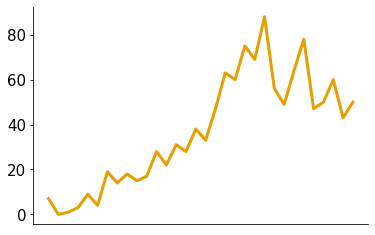

In [44]:
NIS = 21000
ts = 'hospitalised_IN'

all_timeseries = pd.read_csv("../../../COVID19_spatial_private/interim/all_nonpublic_timeseries_arr.csv").fillna(0)
timeseries = all_timeseries[all_timeseries['NIS_arr']==NIS].set_index('DATE')[ts]
# plt.grid(False)
# plt.xticks([])
# plt.plot(timeseries['2020-03-05':'2020-04-05'])

**Execute calibration**

In [58]:
start_date = '2020-03-15'
end_beta = '2020-03-21'
end_ramp = '2020-03-21'
fig_path = './'
samples_path = './'
maxiter = 10 # Way too low for now
popsize = 10 # Way too low for now
steps_mcmc = 10 # Way too low for now: should run in three minutes

# Fix the issue with model attributes!

full_calibration_wave1(model, timeseries, str(NIS), start_date, end_beta, end_ramp, \
                       fig_path, samples_path, initN, Nc_total, maxiter=maxiter, popsize=popsize, steps_mcmc=steps_mcmc)

No constraints given.


ValueError: operands could not be broadcast together with shapes (7,) (12,38) 